In [1]:
import pandas as pd
import seaborn as sns
from  matplotlib import pyplot as plt, ticker, patches
import numpy as np
from scipy.interpolate import Rbf
from datetime import date, timedelta

In [2]:
# For high pixel-density screens, e.g. retina, only
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Make figures bigger
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7
sns.set(style="darkgrid")

In [3]:
url = "https://covid.ourworldindata.org/data/ecdc/full_data.csv"
data = pd.read_csv(url).set_index(["location", "date"]).sort_index()
data.loc["United Kingdom"]

,new_cases,new_deaths,total_cases,total_deaths
date,,,,
2019-12-31,0,0,0,0
2020-01-01,0,0,0,0
2020-01-02,0,0,0,0
2020-01-03,0,0,0,0
2020-01-04,0,0,0,0
...,...,...,...,...
2020-03-18,407,5,1950,60
2020-03-19,680,43,2630,103
2020-03-20,647,41,3277,144


In [4]:
# TODO
# v Gather data for country's testing methodoligies
# v Insert horizontal bars marking the testing methodology
# v Move horizontal bars to the top
# v Get statistics on case timeline (below)
# v Have policy changes be different saturations of blue
# v Create side-plots with daily cases and death rate with same bars but without text
# - have death rate shown on same plot


# Timeline:
# * Incubation Period:
#   - Infected to symptoms: 5.1 days -- https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported
# * Hospitalisation: 
#   - symptoms to hospitalisation: 7 days in China -- https://els-jbs-prod-cdn.literatumonline.com/pb/assets/raw/Lancet/infographics/coronavirus/Coronavirus_MedianTimeline_Infographic-1584612208650.jpg
#   - infected to hospitalisation: 12 days in China -- https://jamanetwork.com/journals/jama/fullarticle/2762130
# * Death
#   - symptoms to death: 14 days median in China -- https://pubmed.ncbi.nlm.nih.gov/31994742/
#   - symptoms to death: 8 days median in Italy -- https://www.epicentro.iss.it/coronavirus/bollettino/Report-COVID-2019_17_marzo-v2.pdf 
# - Show dotted line when we expect the effect of a policy change to start showing

In [7]:
def plot_timeline(title, df, metadata, start_date, ax, show_text = True, x_scale = 1.0, y_scale = 1.0, line_color = None, event_delay = None):
    y = df.to_numpy()
    x = np.linspace(0, len(df)-1, len(df))
    rbf = Rbf(x, y)
    x_interpolate = np.linspace(0, len(df) -1, len(df) * 10)
    y_interpolate = rbf(x_interpolate)
    y_interpolate[y_interpolate < 0] = 0
    line_color = line_color if line_color else sns.color_palette()[0]
     
    event_colors = {
        "case": "tab:orange",
        "death": "tab:red",
        "policy": "tab:blue"
    }
    
    phase_colors = {
        "contain": (0.78, 0.83, 0.90),
        "delay": (0.65, 0.75, 0.85),
    }
    
    plot_ceil = max(y)*(y_scale + 0.7)
    plot_floor = max(y)*-0.02
    data_start_date = pd.to_datetime(df.index[0]).date()
    data_end_date = pd.to_datetime(df.index[-1]).date()
    delay_past_data_end_date = event_delay - (data_end_date - metadata['events'][-1]['date']).days if event_delay else 0
    end_date = data_end_date if event_delay is None else data_end_date + timedelta(delay_past_data_end_date)
    plot_start = (start_date - data_start_date).days
    plot_end = len(df) if event_delay is None else len(df) + delay_past_data_end_date
    plot_width = plot_end - plot_start

    # Set plot width and height
    plt.ylim(plot_floor, plot_ceil)
    plt.xlim(plot_start, plot_end)
    
    # Get the current reference
    ax.set_ylim(plot_floor, plot_ceil)
    ax.set_xlim(plot_start, plot_end)
    
    # Plot rectangle to align bottom of plot with y=0
    rect = patches.Rectangle((plot_start, 0), plot_width, plot_floor, edgecolor='white', facecolor='white', zorder=0.8)
    ax.add_patch(rect)
    
    # Plot phases
    for i, phase in enumerate(metadata['phases']):
        start = phase['from'] if (phase['from'] > start_date) else start_date
        end = phase['to'] if (phase['to'] < end_date) else end_date + timedelta(days=1)
        start_x = (start - start_date).days + plot_start
        start_y = -plot_ceil*0.02
        width = (end - start_date).days + plot_start - start_x
        color = phase_colors[phase['type']]
        rect = patches.Rectangle((start_x, plot_ceil), width, (-plot_ceil*0.055) / y_scale, edgecolor=color, facecolor=color, zorder=0.8)
        ax.add_patch(rect)
        label = "Phase {}: {}".format(i+1, phase['type'].title())
        if show_text:
            ax.text(start_x + width/2.0, plot_ceil*0.985, label, verticalalignment='top', horizontalalignment='center')
    
    # Plot events
    event_palette = sns.color_palette("husl", len(metadata['events'])+1)
    for i, event in enumerate(metadata['events']):
        alpha = 0.8
        event_color = event_palette[i+1]
        days = (event['date'] - start_date).days + plot_start
        ax.axvline(days, 0, 1, color=event_color, alpha=alpha, zorder=0.7)
        if event_delay:
            ax.axvline(days + event_delay, 0, 1, linestyle=':', color=event_color, alpha=alpha, zorder=0.7)
            ax.arrow(days + plot_width*0.01, plot_ceil*(0.5 - i*0.1), event_delay - plot_width*0.02, 0, zorder=0.6, head_width=plot_ceil*0.015/y_scale, head_length=event_delay*0.05, ec=event_color, fc=event_color, alpha=alpha, width=plot_ceil*0.0005, length_includes_head=True)
            #if show_text:
            #    impact_label = "start of impact".format(i+1)
            #    ax.text(days + event_delay - (plot_width*0.02) / x_scale, plot_ceil*0.92, impact_label, rotation=90, verticalalignment='top')
        if show_text:
            label = "{}. {}".format(i+1, event['label'])
            ax.text(days - (plot_width*0.02) / x_scale, plot_ceil*0.92, label, rotation=90, verticalalignment='top')
    
    # Plot extrapolated curve
    sns.lineplot(y=y_interpolate, x=x_interpolate, ax=ax, legend=False, color=line_color)
    
    # Plot discs for actual data points
    sns.scatterplot(data=pd.DataFrame(y, x), ax=ax, legend=False, palette=[line_color])
    
    # Make x-axis have dates
    fmt = ticker.FuncFormatter(lambda x, pos: (data_start_date + timedelta(days=x)).strftime("%b %-d"))
    ax.xaxis.set_major_formatter(fmt)
    
    # Set title and labels
    plt.title("{} {}".format(metadata['country_code'], title.title()))
    if show_text:
        ax.set_ylabel("{}".format(title.title()))
        
    # Draw Legend
    legend = ax.legend([ax.axvline(-10, -10, 1, linestyle='-', color='slategray'), ax.axvline(-10, -10, 1, linestyle=':', color='slategray')], ["Policy Event", "Start of Effect?"], loc="upper left", bbox_to_anchor=(0.02, 1 - (0.08/y_scale)), bbox_transform=ax.transAxes)

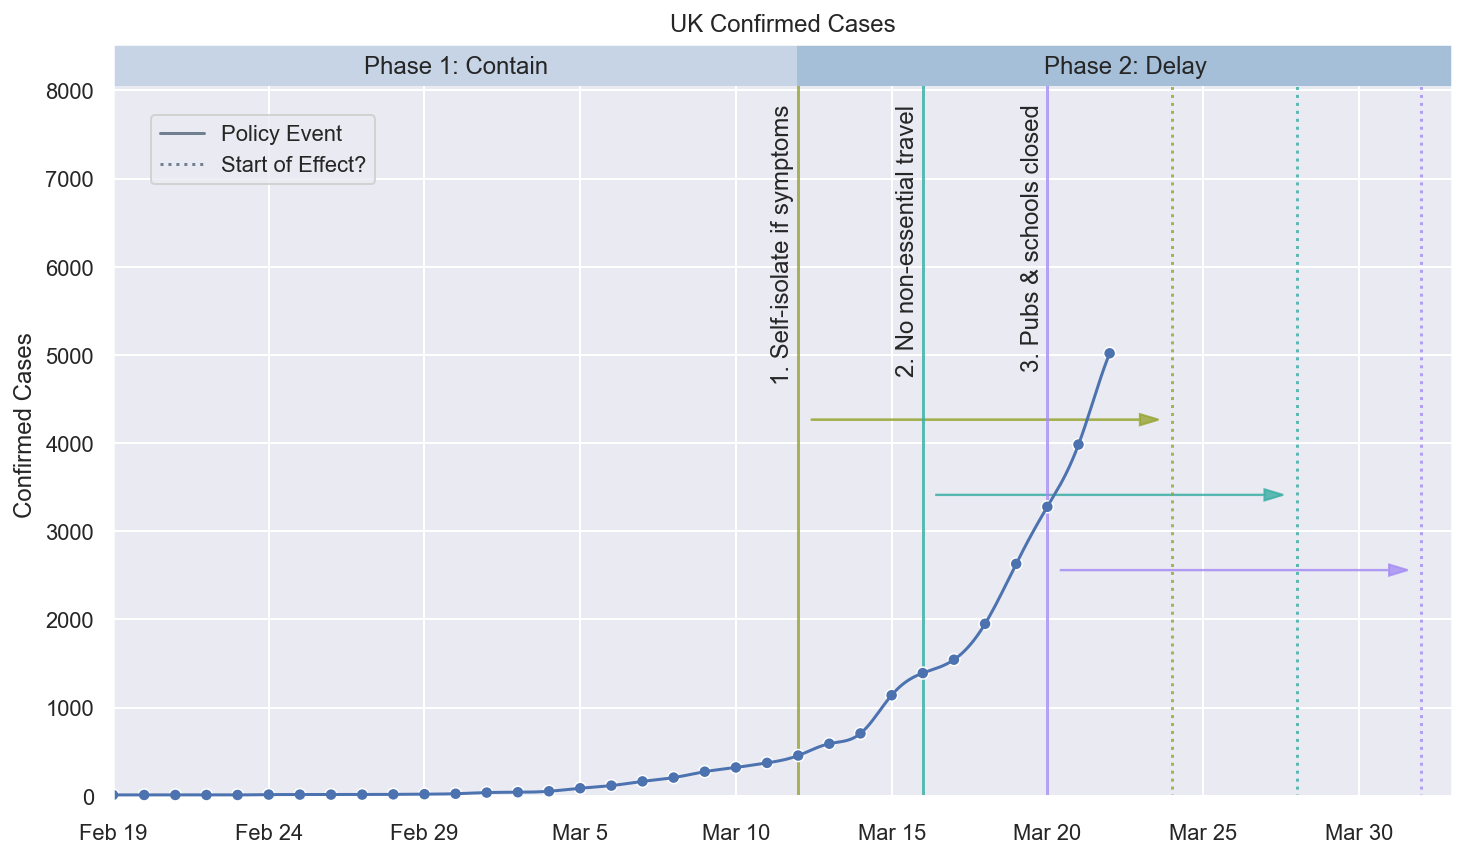

In [8]:

uk_metadata = {
    "country": "the United Kingdom",
    "country_code": "UK",
    "events": [
        #{"type": "case", "label": "10th case", "date": date(2020, 2, 24), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        #{"type": "case", "label": "1st death", "date": date(2020, 3, 5), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        {"type": "policy", "label": "Self-isolate if symptoms", "date": date(2020, 3, 12), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        {"type": "policy", "label": "No non-essential travel", "date": date(2020, 3, 16), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"},
        {"type": "policy", "label": "Pubs & schools closed", "date": date(2020, 3, 20), "source": "https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_United_Kingdom"}
    ],
    "phases": [
        {"type": "contain", "from": date(2020, 1, 1), "to": date(2020, 3, 12), "source": "https://www.theguardian.com/world/2020/mar/12/uk-moves-to-delay-phase-of-coronavirus-plan" },
        {"type": "delay", "from": date(2020, 3, 12), "to": date(2020, 12, 31), "source": "https://www.theguardian.com/world/2020/mar/12/uk-moves-to-delay-phase-of-coronavirus-plan" }
    ]
}

ax0 = plt.gca()
plot_timeline("Confirmed Cases", data.loc['United Kingdom']['total_cases'], uk_metadata, date(2020, 2, 19), ax0, event_delay = 12)


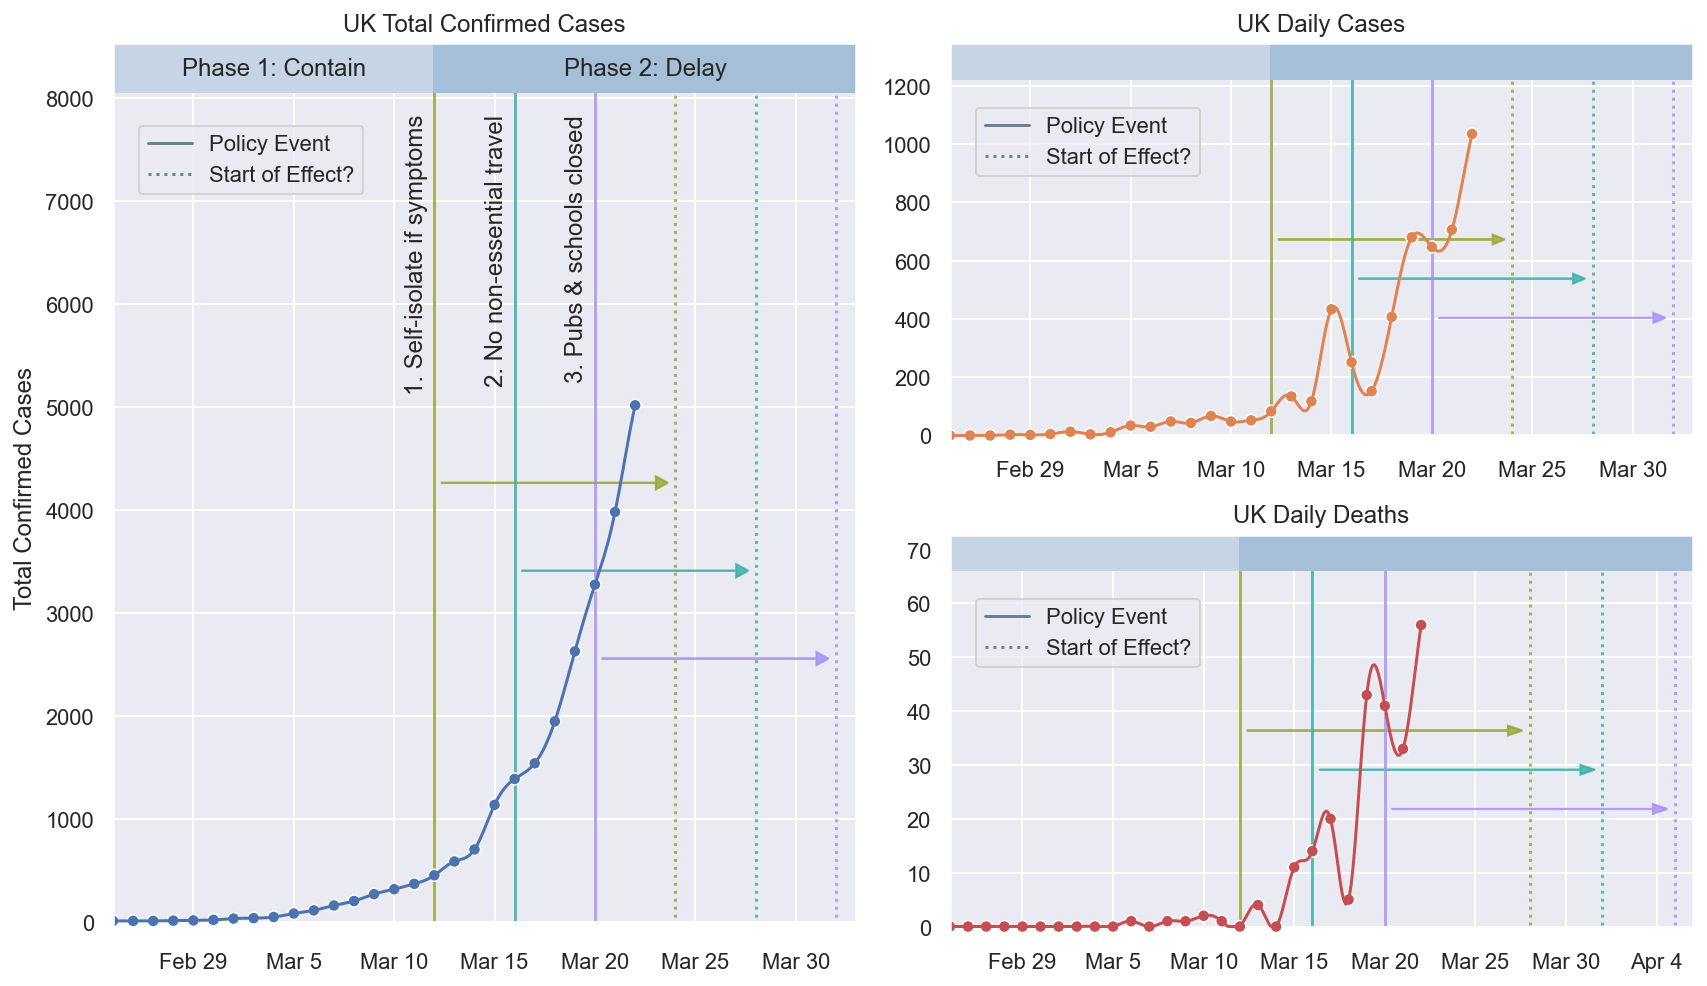

In [9]:
def plot_country(metadata, start_date):
    palette = sns.color_palette()
    ax3 = plt.subplot(121)
    #plot_timeline("Total Confirmed Cases", data.loc['United Kingdom']['total_deaths'], metadata, start_date, ax3, x_scale=0.5, line_color=palette[3])
    plot_timeline("Total Confirmed Cases", data.loc['United Kingdom']['total_cases'], metadata, start_date, ax3, x_scale=0.5, line_color=palette[0], event_delay=12)
    ax1 = plt.subplot(222)
    plot_timeline("Daily Cases", data.loc['United Kingdom']['new_cases'], metadata, start_date, ax1, show_text=False, y_scale=0.6, line_color=palette[1], event_delay=12)
    ax2 = plt.subplot(224)
    plot_timeline("Daily Deaths", data.loc['United Kingdom']['new_deaths'], metadata, start_date, ax2, show_text=False, y_scale=0.6, line_color=palette[3], event_delay=16)
    plt.tight_layout()
    
plot_country(uk_metadata, date(2020, 2, 25))